In [120]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import uniform, norm
from glob import glob
from os.path import join, abspath
from os import pardir
import sys
import vaex
import os
import emcee
from multiprocessing import Pool
from time import time
import corner
from tqdm import tqdm
import pandas as pd

# Utils functions

In [71]:
def plot_chain(samples, labels, figsize=(10, 7), alpha=0.3, start=0, skip=0, path=None):
    num = len(labels)
    fig, axes = plt.subplots(num, figsize=figsize, sharex=True)
    if len(labels) == 1:
      axes = [axes]
    for i in range(num):
        ax = axes[i]
        ax.plot(samples[start:, :, skip:i], "k", alpha=alpha)
        ax.set_xlim(0, len(samples[start:, :, skip:i]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    if path is not None:
        fig.savefig(path, dpi=70)
    fig.show()

In [5]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [6]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [7]:
from utils import nu_mod, fw, safe_mkdir

In [8]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [9]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution-2")
data_eff_dir = join(root_data_dir, "Effective-Volume-2")

In [10]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [11]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

# Math

let $Z=\{z_i\}$ is a collection of vertical positions of the stars, and $W=\{w_i\}$ is a collection of vertical velocities of the stars. We assume that the vertical positions and velocities are independent. $Z$ and $W$ are inhomogeneous Poisson processes with intensity $\lambda(z)$ and $\mu(w)$ respectively. The intensity $\lambda(z)$ is the number density of star in vertical direction, and $\mu(w)$ is the number density of stars at some velocity $w$.

From previous notebook, the intensity $\lambda(z)$ can be calculated depent on the following parameters $\theta$:
* $\rho_{i}$ - the density of the baryons
* $\sigma_{z,i}$ - baryons velocity dispersion in vertical direction
* $\rho_{\text{DM}}$ - the density of the dark matter halo in the vicinity of the sun
* $\Sigma_{\text{DD}}$ - surface density of dark disk
* $h_{\text{DD}}$ - the vertical scale height of dark disk
* $\nu_0$ - the number density of stars in the midplane disk
* $z_{\odot}$ - the position of the sun
* $R$ - Oort constant radial contribution
* $\sigma_w$ - the velocity dispersion of the stars in vertical direction
* $w_0$ - the velocity of the sun

So,
\begin{aligned}
  \lambda (z) &= f(z;\theta) \\
  &= \nu(z;\theta) \mathcal{F} (z) \\
  &= \nu_0 \exp \left[ -\frac{\Phi(z+z_{\odot};\rho_i,\sigma_{z,i}, \rho_{\text{DM}}, \Sigma_{\text{DD}}, h_{\text{DD}}, R )}{\sigma_w^2} \right] \mathcal{F} (z)\\
\end{aligned}

Where $\mathcal{F} (z)$ is the completeness function

and the same goes for the intensity $\mu(w)$:
\begin{aligned}
  \mu (w) &= g(w;\theta) \\
  &= N_0\mathcal{N}(w;\sigma_w, w_0)
\end{aligned}

Where $N_0$ is the normalization constant

# Framework

by using Bayesian Statistics, we can calculate the posterior distribution of the parameters $\theta$ given the data $Z$ and $W$:
\begin{aligned}
  p_\text{pos}(\theta|Z,W) &= \frac{p_\text{like}(Z,W|\theta)p_\text{prior}(\theta)}{p_\text{ev}(Z,W)} \\
  &\propto p_\text{like,Z}(Z|\theta)p_\text{like,W}(W|\theta) p_0(\theta) \\
  &\propto \mathcal{L}_z(Z|\theta)\mathcal{L}_w(W|\theta) p_0(\theta) \\
  \text{log } p_\text{pos}(\theta|Z,W) &= \text{log } \mathcal{L}_z(Z|\theta) + \text{log } \mathcal{L}_w(W|\theta) + \text{log } p_0(\theta) + C\\
\end{aligned}

Where the likelihood is the likelihood of inhomogeneous Poisson process,
\begin{aligned}
  \text{log } \mathcal{L}_z(Z|\theta) &= \sum_i \log \lambda(z_i) - \int \lambda(z) \text{ d}z \\
  \text{log } \mathcal{L}_w(W|\theta) &= \sum_i \log \mu(w_i) - \int \mu(w) \text{ d}w \\
\end{aligned}

### Prior

Either we can use a uniform prior or a Gaussian prior. The uniform prior is represented by [lower, upper].
| Parameter | Prior | Description |
| --- | --- | --- |
| $\rho_{i}$ | Gaussian | Check the baryons table |
| $\sigma_{z,i}$ | Gaussian | Check the baryons table |
| $\rho_{\text{DM}}$ | [0, 0.06] msun/pc^3 |  |
| $\Sigma_{\text{DD}}$ | [0, 30] msun/pc^2 | |
| $h_{\text{DD}}$ | [0, 100] pc |  |
| $\text{log }\nu_0$ | [12, 13] | A star (star/kpc^3) |
|  | [14, 14.4] | F star |
|  | [13.8, 14] | G star |
| $z_{\odot}$ | [-50, 50] pc | |
| $R$ | Gaussian | mean=3.4E-3, std=0.6E-3 in msun/pc^3|
| $\sigma_w$ | [1, 20] km/s | |
| $w_0$ | [-20, 20] km/s | |

# Prototyping

In [12]:
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
number_files

['/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(-0.10)_(0.04).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.04)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.10)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.14)_(0.18).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.18)_(0.21).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.21)_(0.24).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.24)_(0.27).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.27)_(0.29).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.29)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.34)_(0.36).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.36)_(0.38

In [14]:
index = 6
df_number = vaex.open(number_files[index])
df_number

#,z,density_corr,density,density_err
0,-351.4736842105263,3.1866752885635777e-06,2.4023387636512506e-06,2.838915983977117e-07
1,-312.42105263157896,3.5455239773303575e-06,2.650199112281935e-06,3.0072741874865094e-07
2,-273.36842105263156,4.37493726596723e-06,3.241250712862798e-06,3.3554237114005015e-07
3,-234.31578947368422,5.92189823615915e-06,4.347089191368929e-06,3.921872914519602e-07
4,-195.26315789473682,5.9259306159549535e-06,4.308956830041132e-06,3.941870410058617e-07
...,...,...,...,...
14,195.26315789473682,7.866279578701265e-06,5.719854199169643e-06,4.541598632284031e-07
15,234.31578947368422,5.792032046769695e-06,4.251758288049435e-06,3.878631538920876e-07
16,273.3684210526316,4.760961142376103e-06,3.5272434228212802e-06,3.5003282470953493e-07
17,312.421052631579,3.239435576409751e-06,2.421404944315149e-06,2.8745342455613333e-07


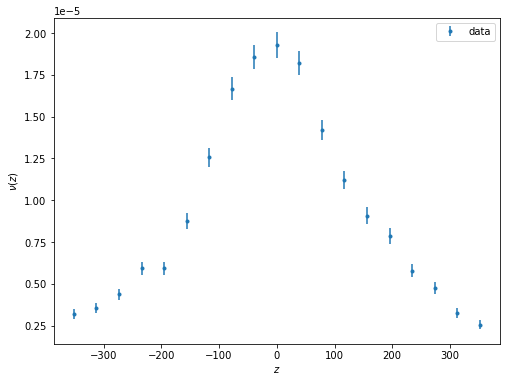

In [15]:
zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\nu(z)$')
ax.legend()
plt.show()

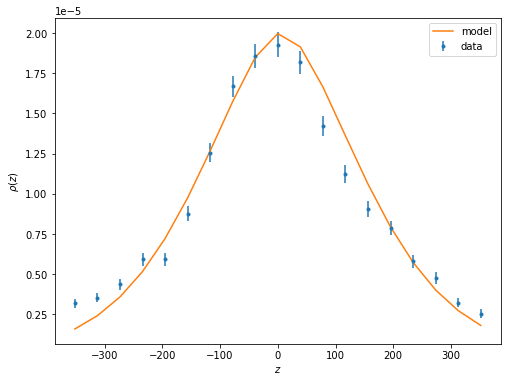

In [21]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 2E-5
zsun = -6

theta_dict = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R,
    sigma_w=np.array([11]),
    w0=np.array([-7]),
    a=np.array([1])
)

nu = nu_mod(zmid, **theta_dict)

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
ax.plot(zmid, nu, label='model')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.legend()
plt.show()

In [22]:
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(-0.10)_(0.04).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.04)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.10)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.14)_(0.18).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.18)_(0.21).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.21)_(0.24).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.24)_(0.27).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.27)_(0.29).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.29)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.34)_(0.36).hdf5',
 '/home2/s20321005/T

In [23]:
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()
velocity_popt_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(-0.10)_(0.04).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.04)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.10)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.14)_(0.18).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.18)_(0.21).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.21)_(0.24).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.24)_(0.27).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.27)_(0.29).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.29)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distributio

In [24]:
df_velocity = vaex.open(velocity_files[index])
df_velocity

#,w,wnum,werr
0,-53.21106749277028,9.301682201466447e-05,5.370328722933004e-05
1,-48.04244078250238,0.0009301682201466447,0.0001698247054829162
2,-42.87381407223448,0.001767319618278625,0.00023408720196858808
3,-37.70518736196657,0.0030075439118074847,0.00030536981773246925
4,-32.536560651698665,0.00415475138332168,0.0003589158536192078
...,...,...,...
14,19.14970645098039,0.0027594990531017126,0.00029250631461673733
15,24.318333161248297,0.0008371513981319802,0.00016110986168799013
16,29.4869598715162,0.0011472074715141952,0.00018859974654607318
17,34.65558658178411,0.0002790504660439934,9.301682201466447e-05


In [25]:
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
popt

array([ 0.5313801 , -6.7145192 , 15.10582341,  0.46613444, -6.70622469,
        7.95089686])

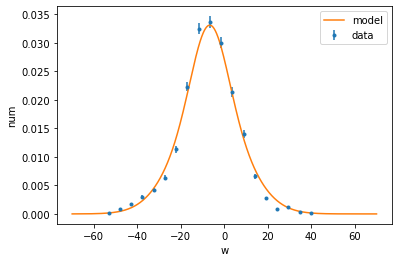

In [26]:
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()

w0 = []
sigma_w = []
a_raw = []

for i in range(len(popt)//3):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

w0 = np.array(w0)
sigma_w = np.array(sigma_w)
a_raw = np.array(a_raw)

theta = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R, 
    w0=w0, 
    sigma_w=sigma_w, 
    a=a_raw
)

ws = np.linspace(-70, 70, 1000)
Fw = fw(ws, **theta)

# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
ax.plot(ws, Fw, label='model')
ax.set_xlabel(r'w')
ax.set_ylabel(r'num')
ax.legend()
plt.show()

In [27]:
args = ('rhos', 'sigmaz', 'rhoDM', 'sigmaDD', 'hDD', 'nu0', 'zsun', 'R', 'sigma_w', 'w0', 'a')

args_loc = tuple(item+"_loc" for item in args)
args_loc

('rhos_loc',
 'sigmaz_loc',
 'rhoDM_loc',
 'sigmaDD_loc',
 'hDD_loc',
 'nu0_loc',
 'zsun_loc',
 'R_loc',
 'sigma_w_loc',
 'w0_loc',
 'a_loc')

In [28]:
uni_list = ['rhoDM', 'log_sigmaDD', 'log_hDD', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list = ['rhos', 'sigmaz', 'R']
args = tuple(norm_list+uni_list)
args

('rhos',
 'sigmaz',
 'R',
 'rhoDM',
 'log_sigmaDD',
 'log_hDD',
 'log_nu0',
 'zsun',
 'log_sigma_w',
 'w0',
 'a')

In [29]:
uni_list = ['rhoDM', 'log_sigmaDD', 'log_hDD', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list = ['rhos', 'sigmaz', 'R']
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [33]:
locs = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=-0.05, 
    log_sigmaDD=np.log(1), 
    log_hDD=np.log(1), 
    log_nu0=np.log(1E-6), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=a_raw*0.7
    # a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    rhos=e_rhos, 
    sigmaz=e_sigmaz, 
    rhoDM=0.1-locs['rhoDM'], 
    log_sigmaDD=np.log(50)-locs['log_sigmaDD'], 
    log_hDD=np.log(100)-locs['log_hDD'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=10, 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)
locs, scales

({'rhos': array([0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018, 0.0018, 0.0029,
         0.0072, 0.0216, 0.0056, 0.0015]),
  'sigmaz': array([ 3.7,  7.1, 22.1, 39. , 15.5,  7.5, 12. , 18. , 18.5, 18.5, 20. ,
         20. ]),
  'rhoDM': -0.05,
  'log_sigmaDD': 0.0,
  'log_hDD': 0.0,
  'log_nu0': -13.815510557964274,
  'zsun': -20,
  'R': 0.0034,
  'w0': array([-11.7145192 , -11.70622469]),
  'log_sigma_w': array([2.35840538, 1.71660979]),
  'a': array([0.37196607, 0.32629411])},
 {'rhos': array([3.12e-03, 5.54e-03, 7.00e-04, 3.00e-05, 6.00e-05, 1.80e-04,
         1.80e-04, 2.90e-04, 7.20e-04, 2.80e-03, 1.00e-03, 5.00e-04]),
  'sigmaz': array([0.2, 0.5, 2.4, 4. , 1.6, 2. , 2.4, 1.8, 1.9, 4. , 5. , 5. ]),
  'rhoDM': 0.15000000000000002,
  'log_sigmaDD': 3.912023005428146,
  'log_hDD': 4.605170185988092,
  'log_nu0': 4.605170185988092,
  'zsun': 40,
  'R': 0.0006,
  'w0': 10,
  'log_sigma_w': array([0.61903921, 0.61903921]),
  'a': array([0.31882806, 0.27968066])})

In [34]:
dim=len(popt)//3
theta_dict = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    log_sigmaDD=np.log(sigmaDD), 
    log_hDD=np.log(hDD), 
    log_nu0=np.log(2E-5), 
    zsun=20, 
    R=R, 
    w0=w0, 
    log_sigma_w=np.log(sigma_w), 
    a=a_raw
)

log_prior(theta_dict, locs, scales, norm_list, uni_list)

60.55293165326831

In [35]:
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [36]:
zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])

log_likelihood(theta_dict, zdata, wdata)

235.39602620881644

In [37]:
def log_posterior(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=theta[:12],
        sigmaz=theta[12:24],
        rhoDM=theta[24],
        log_sigmaDD=theta[25],
        log_hDD=theta[26],
        log_nu0=theta[27],
        zsun=theta[28],
        R=theta[29],
        w0=theta[30:30+dim],
        log_sigma_w=theta[30+dim:30+2*dim],
        a=theta[30+2*dim:30+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf

    theta_dict['sigmaDD'] = np.exp(theta_dict['log_sigmaDD'])
    theta_dict['hDD'] = np.exp(theta_dict['log_hDD'])
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [38]:
theta = [
    rhos, 
    sigmaz, 
    rhoDM, 
    np.log(sigmaDD), 
    np.log(hDD), 
    np.log(4E-5), 
    20, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])
log_posterior(theta, (zdata, wdata), locs, scales, dim, norm_list, uni_list)

-3841.9143472101573

In [39]:
def log_posterior_simple_DM(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        rhoDM=theta[0],
        log_nu0=theta[1],
        zsun=theta[2],
        R=theta[3],
        w0=theta[4:4+dim],
        log_sigma_w=theta[4+dim:4+2*dim],
        a=theta[4+2*dim:4+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf
    
    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [41]:
# dm only

theta = [
    rhoDM, 
    np.log(2E-5), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    rhoDM=-0.05, 
    log_nu0=np.log(1E-5), 
    zsun=-20, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    rhoDM=0.1-locs['rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=20-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']

log_posterior_simple_DM(theta, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM), theta.shape

(117.18638806640128, (10,))

# MCMC

In [42]:
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
number_files

['/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(-0.10)_(0.04).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.04)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.10)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.14)_(0.18).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.18)_(0.21).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.21)_(0.24).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.24)_(0.27).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.27)_(0.29).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.29)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.34)_(0.36).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Effective-Volume-2/gaia_(0.36)_(0.38

In [43]:
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(-0.10)_(0.04).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.04)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.10)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.14)_(0.18).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.18)_(0.21).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.21)_(0.24).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.24)_(0.27).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.27)_(0.29).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.29)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/gaia_(0.34)_(0.36).hdf5',
 '/home2/s20321005/T

In [44]:
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()
velocity_popt_files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(-0.10)_(0.04).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.04)_(0.10).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.10)_(0.14).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.14)_(0.18).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.18)_(0.21).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.21)_(0.24).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.24)_(0.27).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.27)_(0.29).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.29)_(0.32).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution-2/popt_gaia_(0.32)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distributio

In [45]:
name = "MCMC-2"
data_dir = join(root_data_dir, name)
safe_mkdir(data_dir)

Directory /home2/s20321005/Thesis-Project/Data/MCMC-2 already exist. Good to go!


# Prob

In [46]:
# prior
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [47]:
# likelihood
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [48]:
# posterior DM only
def log_posterior_simple_DM(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        rhoDM=theta[0],
        log_nu0=theta[1],
        zsun=theta[2],
        R=theta[3],
        w0=theta[4:4+dim],
        log_sigma_w=theta[4+dim:4+2*dim],
        a=theta[4+2*dim:4+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf

    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

In [50]:
# Loading data
index = 6
df_number = vaex.open(number_files[index])
df_number

#,z,density_corr,density,density_err
0,-351.4736842105263,3.1866752885635777e-06,2.4023387636512506e-06,2.838915983977117e-07
1,-312.42105263157896,3.5455239773303575e-06,2.650199112281935e-06,3.0072741874865094e-07
2,-273.36842105263156,4.37493726596723e-06,3.241250712862798e-06,3.3554237114005015e-07
3,-234.31578947368422,5.92189823615915e-06,4.347089191368929e-06,3.921872914519602e-07
4,-195.26315789473682,5.9259306159549535e-06,4.308956830041132e-06,3.941870410058617e-07
...,...,...,...,...
14,195.26315789473682,7.866279578701265e-06,5.719854199169643e-06,4.541598632284031e-07
15,234.31578947368422,5.792032046769695e-06,4.251758288049435e-06,3.878631538920876e-07
16,273.3684210526316,4.760961142376103e-06,3.5272434228212802e-06,3.5003282470953493e-07
17,312.421052631579,3.239435576409751e-06,2.421404944315149e-06,2.8745342455613333e-07


In [51]:
zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

In [52]:
# loading velocity data
df_velocity = vaex.open(velocity_files[index])
df_velocity

#,w,wnum,werr
0,-53.21106749277028,9.301682201466447e-05,5.370328722933004e-05
1,-48.04244078250238,0.0009301682201466447,0.0001698247054829162
2,-42.87381407223448,0.001767319618278625,0.00023408720196858808
3,-37.70518736196657,0.0030075439118074847,0.00030536981773246925
4,-32.536560651698665,0.00415475138332168,0.0003589158536192078
...,...,...,...
14,19.14970645098039,0.0027594990531017126,0.00029250631461673733
15,24.318333161248297,0.0008371513981319802,0.00016110986168799013
16,29.4869598715162,0.0011472074715141952,0.00018859974654607318
17,34.65558658178411,0.0002790504660439934,9.301682201466447e-05


In [53]:
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
popt

array([ 0.5313801 , -6.7145192 , 15.10582341,  0.46613444, -6.70622469,
        7.95089686])

In [54]:
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()

dim = len(popt)//3

w0 = []
sigma_w = []
a_raw = []

for i in range(dim):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

w0 = np.array(w0)
sigma_w = np.array(sigma_w)
a_raw = np.array(a_raw)

In [56]:
# dm only
theta = [
    0.02, 
    np.log(2E-5), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    rhoDM=-0.05, 
    log_nu0=np.log(1E-6), 
    zsun=-40, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=a_raw*0.7
    # a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    rhoDM=0.1-locs['rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=40-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']

log_posterior_simple_DM(theta, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM), theta.shape

(152.73856319553633, (10,))

In [57]:
theta = np.concatenate([np.ravel(x) for x in locs.values()])

ndim = len(theta)
nwalkers = ndim*2+1
pars_list = uni_list_DM + norm_list_DM

rhoDM_0 = np.random.uniform(low=locs['rhoDM'], high=locs['rhoDM']+scales['rhoDM'], size=nwalkers)
log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

p0 = np.array([rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
p0.shape

(21, 10)

In [58]:
p00 = p0[3]
theta_dict = dict(
    rhoDM=p00[0],
    log_nu0=p00[1],
    zsun=p00[2],
    R=p00[3],
    w0=p00[4:4+dim],
    log_sigma_w=p00[4+dim:4+2*dim],
    a=p00[4+2*dim:4+3*dim]
)

log_prior(theta_dict, locs, scales, norm_list_DM, uni_list_DM)

0.7943863322521669

In [61]:
for p00 in p0:
    print(log_posterior_simple_DM(p00, (zdata, wdata), locs, scales, dim, norm_list_DM, uni_list_DM))

-4582.054230556557
-339.4603306995305
-21837.50482506808
-508.2091648597368
-1743.6713405779203
-933.0090997630482
-56984.06472415975
-25306.889069912853
-867.8134128212782
-45429.86016979444
-4322.816792070876
-2476.4582977428963
-2533.081160068424
-2345.225274979212
-1898.2825694734904
-1418.678986330293
-2484.6556486671034
-136.1120711257185
-1916.1613729409055
-477.9034238909138
-2241.69178850477


100%|██████████| 500/500 [00:42<00:00, 11.85it/s]


Multiprocessing took 42.3 seconds


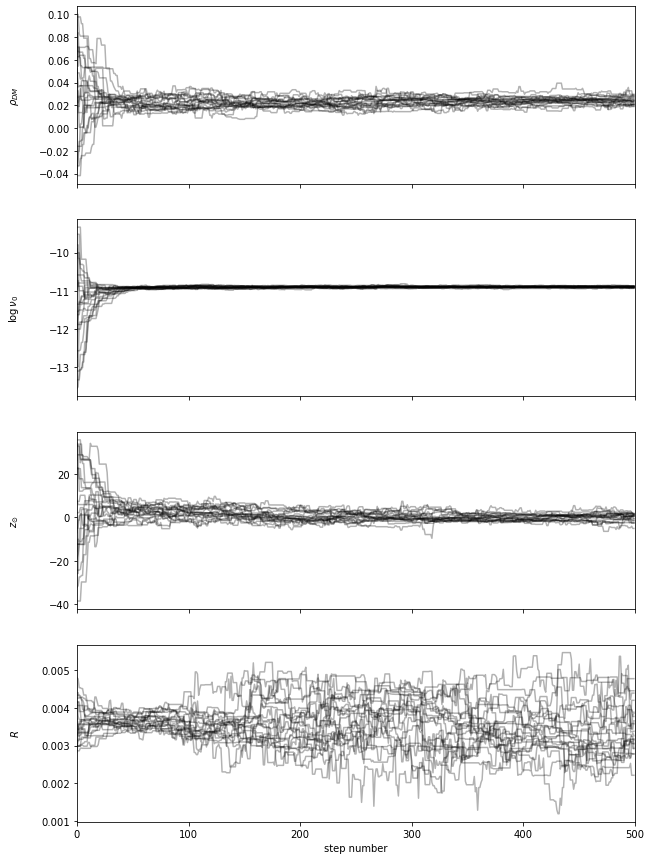

In [62]:
from time import time

os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

labels = [r"$\rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
data = (zdata, wdata)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(p0, 500, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

100%|██████████| 2000/2000 [02:47<00:00, 11.95it/s]


Multiprocessing took 167.5 seconds


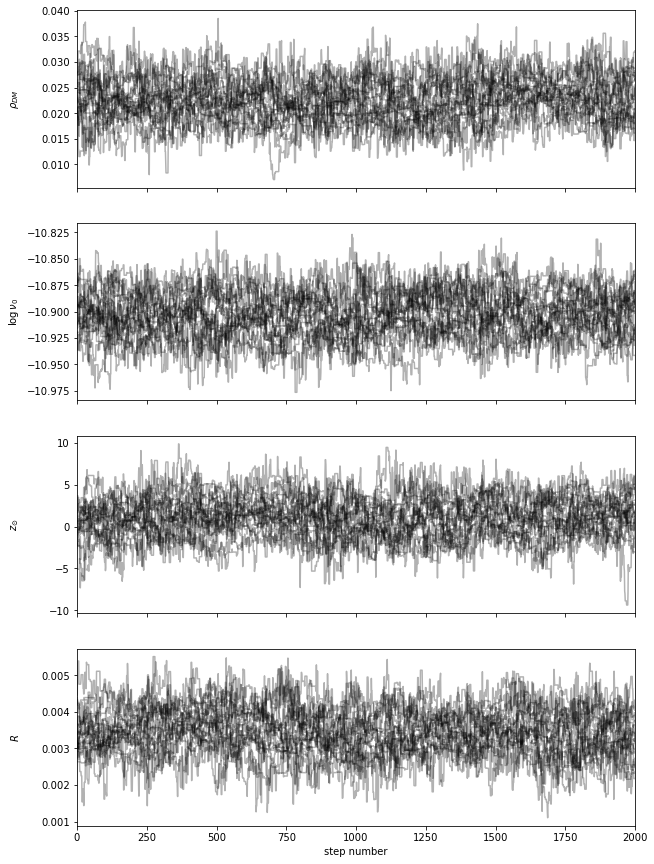

In [63]:
next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

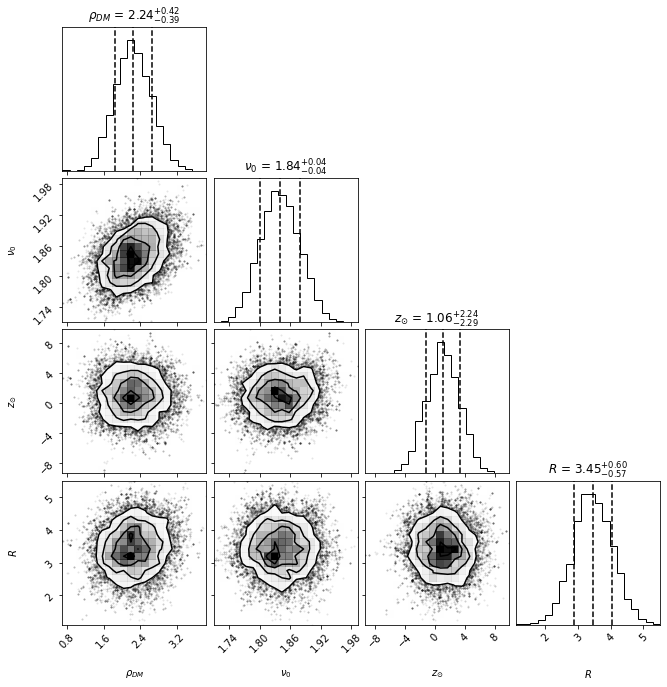

In [64]:
flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples = flat_samples[:, :4]
flat_samples[:, 0] = flat_samples[:, 0]/1E-2
flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
flat_samples[:, 3] = flat_samples[:, 3]/1E-3

labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
fig = corner.corner(
    flat_samples, labels=labels_2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

100%|██████████| 300/300 [00:08<00:00, 34.14it/s]


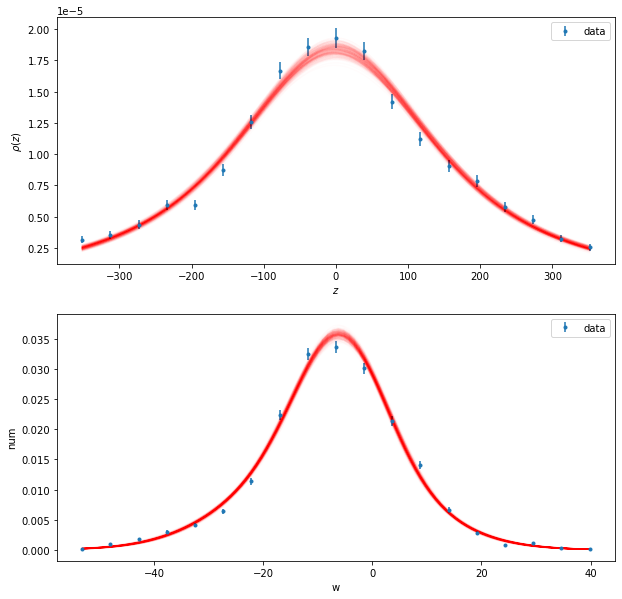

In [65]:
# plot two subplot
flat_samples = sampler_.get_chain(flat=True).copy()
alpha=0.01
zs = np.linspace(zmid.min(), zmid.max(), 100)
ws = np.linspace(wmid.min(), wmid.max(), 100)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\rho(z)$')
axes[0].legend()
axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
axes[1].set_xlabel(r'w')
axes[1].set_ylabel(r'num')
axes[1].legend()
for i in tqdm(range(300)):
    index = np.random.randint(0, len(flat_samples))
    theta_dict = dict(
        rhos=rhos, 
        sigmaz=sigmaz, 
        rhoDM=flat_samples[index, 0],
        sigmaDD=0, 
        hDD=1, 
        nu0=np.exp(flat_samples[index, 1]),
        zsun=flat_samples[index, 2],
        R=flat_samples[index, 3],
        w0=flat_samples[index, 4:4+dim],
        sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
        a=flat_samples[index, 4+2*dim:4+3*dim]
    )
    nu = nu_mod(zs, **theta_dict)
    axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
    Fw = fw(ws, **theta_dict)
    axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
plt.show()

# All in one go

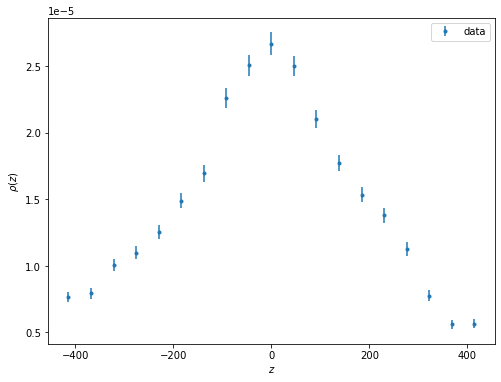

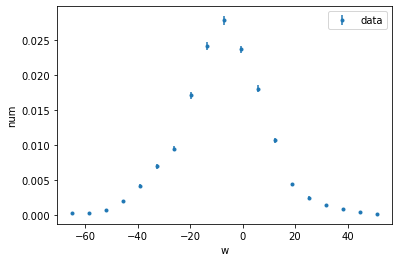

100%|██████████| 500/500 [00:43<00:00, 11.53it/s]


Multiprocessing took 43.5 seconds


100%|██████████| 2000/2000 [02:48<00:00, 11.88it/s]


Multiprocessing took 168.5 seconds


100%|██████████| 300/300 [00:08<00:00, 35.56it/s]


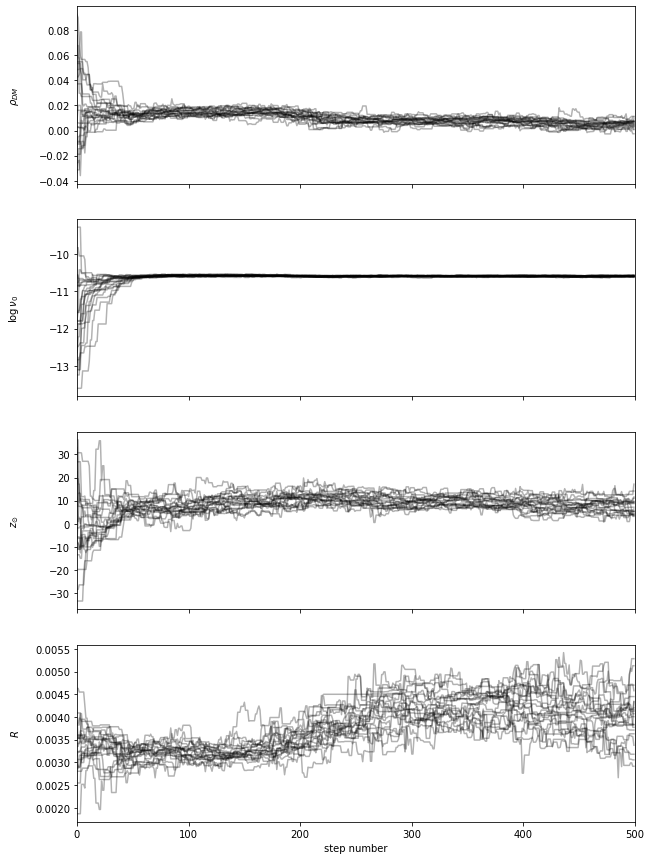

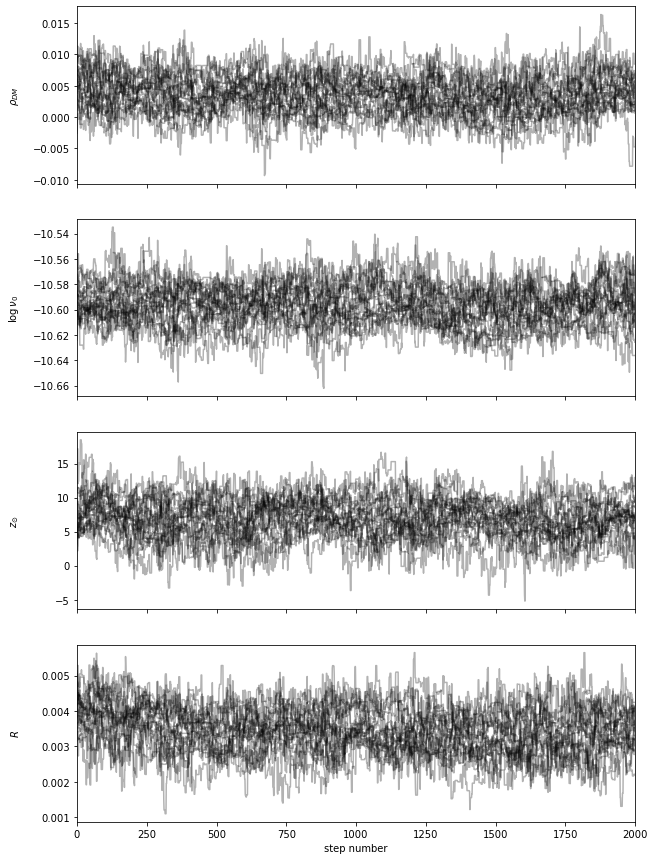

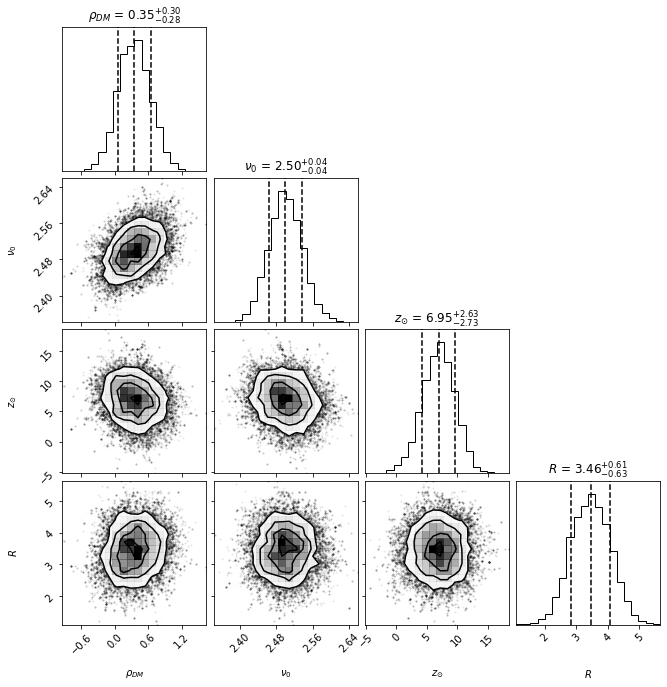

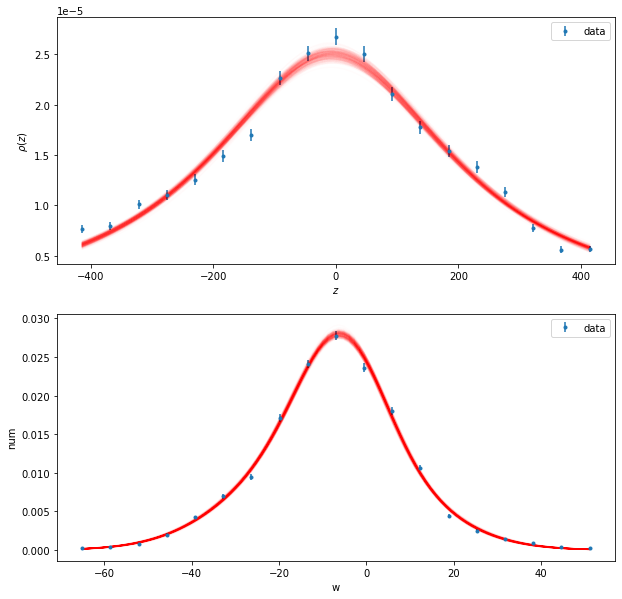

In [66]:
index = 8
# loading the data
df_number = vaex.open(number_files[index])
df_velocity = vaex.open(velocity_files[index])
df_popt = vaex.open(velocity_popt_files[index])
popt = df_popt['popt'].to_numpy()
wdens= df_velocity['wnum'].to_numpy()
werr = df_velocity['werr'].to_numpy()
wmid = df_velocity['w'].to_numpy()
dim = len(popt)//3

zdens = df_number['density_corr'].to_numpy()
zerr = df_number['density_err'].to_numpy()
zmid = df_number['z'].to_numpy()

w0 = []
sigma_w = []
a_raw = []

for i in range(len(popt)//3):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

w0 = np.array(w0)
sigma_w = np.array(sigma_w)
a_raw = np.array(a_raw)

zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)
data = (zdata, wdata)

# ======================================
# plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rho(z)$')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
ax.set_xlabel(r'w')
ax.set_ylabel(r'num')
ax.legend()
plt.show()
# ======================================
# initialize the locs and scales
# dm only
theta = [
    0.02, 
    np.log(4E-5), 
    10, 
    R, 
    w0, 
    np.log(sigma_w), 
    a_raw
]
# flatten the list
theta = np.concatenate([np.ravel(x) for x in theta])

locs = dict(
    rhoDM=-0.05, 
    log_nu0=np.log(1E-6), 
    zsun=-40, 
    R=R, 
    w0=w0-5, 
    log_sigma_w=np.log(sigma_w*0.7), 
    a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
)

scales = dict(
    rhoDM=0.1-locs['rhoDM'], 
    log_nu0=np.log(1E-4)-locs['log_nu0'], 
    zsun=40-locs['zsun'], 
    R=0.6E-3, 
    w0=np.repeat(10, dim), 
    log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
    a=np.abs(a_raw*0.6)
)

zdata = (zmid, zdens, zerr)
wdata = (wmid, wdens, werr)

uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
norm_list_DM = ['R']
# ======================================
# initialize the walkers
theta = np.concatenate([np.ravel(x) for x in locs.values()])

ndim = len(theta)
nwalkers = ndim*2+1
pars_list = uni_list_DM + norm_list_DM
index = 0

rhoDM_0 = np.random.uniform(low=locs['rhoDM'], high=locs['rhoDM']+scales['rhoDM'], size=nwalkers)
log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

p0 = np.array([rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T

os.environ["OMP_NUM_THREADS"] = "16"
sampler_ = 0

labels = [r"$\rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
data = (zdata, wdata)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(p0, 500, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

next_p0 = sampler_.get_chain()[-1]
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, 
        ndim, 
        log_posterior_simple_DM, 
        args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
        pool=pool
    )
    start = time()
    state = sampler.run_mcmc(next_p0, 2000, progress=True)
    samples = sampler.get_chain()
    end = time()
    multi_time = end - start
    plot_chain(samples, labels, figsize=(10,15))
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    sampler_ = sampler

flat_samples = sampler_.get_chain(flat=True).copy()
flat_samples = flat_samples[:, :4]
flat_samples[:, 0] = flat_samples[:, 0]/1E-2
flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
flat_samples[:, 3] = flat_samples[:, 3]/1E-3


labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
fig = corner.corner(
    flat_samples, labels=labels_2,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={"fontsize": 12},
)

# plot two subplot
flat_samples = sampler_.get_chain(flat=True).copy()
alpha=0.01
zs = np.linspace(zmid.min(), zmid.max(), 100)
ws = np.linspace(wmid.min(), wmid.max(), 100)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
axes[0].set_xlabel(r'$z$')
axes[0].set_ylabel(r'$\rho(z)$')
axes[0].legend()
axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
axes[1].set_xlabel(r'w')
axes[1].set_ylabel(r'num')
axes[1].legend()
for i in tqdm(range(300)):
    index = np.random.randint(0, len(flat_samples))
    theta_dict = dict(
        rhos=rhos, 
        sigmaz=sigmaz, 
        rhoDM=flat_samples[index, 0],
        sigmaDD=0, 
        hDD=1, 
        nu0=np.exp(flat_samples[index, 1]),
        zsun=flat_samples[index, 2],
        R=flat_samples[index, 3],
        w0=flat_samples[index, 4:4+dim],
        sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
        a=flat_samples[index, 4+2*dim:4+3*dim]
    )
    nu = nu_mod(zs, **theta_dict)
    axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
    Fw = fw(ws, **theta_dict)
    axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
plt.show()

In [ ]:
# for i in range(13):
#     index = i
#     # loading the data
#     df_number = vaex.open(number_files[index])
#     df_velocity = vaex.open(velocity_files[index])
#     df_popt = vaex.open(velocity_popt_files[index])
#     popt = df_popt['popt'].to_numpy()
#     wdens= df_velocity['wnum'].to_numpy()
#     werr = df_velocity['werr'].to_numpy()
#     wmid = df_velocity['w'].to_numpy()
#     dim = len(popt)//3

#     zdens = df_number['density_corr'].to_numpy()
#     zerr = df_number['density_err'].to_numpy()
#     zmid = df_number['z'].to_numpy()

#     w0 = []
#     sigma_w = []
#     a_raw = []

#     for i in range(len(popt)//3):
#         w0_i = popt[3*i+1]
#         sigma_w_i = popt[3*i+2]
#         a_raw_i = popt[3*i]
        
#         w0.append(w0_i)
#         sigma_w.append(sigma_w_i)
#         a_raw.append(a_raw_i)

#     w0 = np.array(w0)
#     sigma_w = np.array(sigma_w)
#     a_raw = np.array(a_raw)

#     zdata = (zmid, zdens, zerr)
#     wdata = (wmid, wdens, werr)
#     data = (zdata, wdata)

#     # ======================================
#     # plot the data
#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
#     ax.set_xlabel(r'$z$')
#     ax.set_ylabel(r'$\rho(z)$')
#     ax.legend()
#     plt.show()

#     fig, ax = plt.subplots(figsize=(6, 4))
#     ax.errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
#     ax.set_xlabel(r'w')
#     ax.set_ylabel(r'num')
#     ax.legend()
#     plt.show()
#     # ======================================
#     # initialize the locs and scales
#     # dm only
#     theta = [
#         0.02, 
#         np.log(4E-5), 
#         10, 
#         R, 
#         w0, 
#         np.log(sigma_w), 
#         a_raw
#     ]
#     # flatten the list
#     theta = np.concatenate([np.ravel(x) for x in theta])

#     locs = dict(
#         rhoDM=-0.05, 
#         log_nu0=np.log(1E-6), 
#         zsun=-40, 
#         R=R, 
#         w0=w0-5, 
#         log_sigma_w=np.log(sigma_w*0.7), 
#         a=np.select([a_raw > 0], [a_raw*0.7], default=a_raw*1.3)
#     )

#     scales = dict(
#         rhoDM=0.1-locs['rhoDM'], 
#         log_nu0=np.log(1E-4)-locs['log_nu0'], 
#         zsun=40-locs['zsun'], 
#         R=0.6E-3, 
#         w0=np.repeat(10, dim), 
#         log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
#         a=np.abs(a_raw*0.6)
#     )

#     zdata = (zmid, zdens, zerr)
#     wdata = (wmid, wdens, werr)

#     uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
#     norm_list_DM = ['R']
#     # ======================================
#     # initialize the walkers
#     theta = np.concatenate([np.ravel(x) for x in locs.values()])

#     ndim = len(theta)
#     nwalkers = ndim*2+1
#     pars_list = uni_list_DM + norm_list_DM
#     index = 0

#     rhoDM_0 = np.random.uniform(low=locs['rhoDM'], high=locs['rhoDM']+scales['rhoDM'], size=nwalkers)
#     log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
#     zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
#     R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
#     w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
#     log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
#     a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

#     p0 = np.array([rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T

#     os.environ["OMP_NUM_THREADS"] = "16"
#     sampler_ = 0

#     labels = [r"$\rho_{DM}$",r"$\log \nu_0$" , r"$z_{\odot}$", r"$R$"]
#     data = (zdata, wdata)
#     with Pool() as pool:
#         sampler = emcee.EnsembleSampler(
#             nwalkers, 
#             ndim, 
#             log_posterior_simple_DM, 
#             args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
#             pool=pool
#         )
#         start = time()
#         state = sampler.run_mcmc(p0, 500, progress=True)
#         samples = sampler.get_chain()
#         end = time()
#         multi_time = end - start
#         plot_chain(samples, labels, figsize=(10,15))
#         print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#         sampler_ = sampler

#     next_p0 = sampler_.get_chain()[-1]
#     with Pool() as pool:
#         sampler = emcee.EnsembleSampler(
#             nwalkers, 
#             ndim, 
#             log_posterior_simple_DM, 
#             args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
#             pool=pool
#         )
#         start = time()
#         state = sampler.run_mcmc(next_p0, 2000, progress=True)
#         samples = sampler.get_chain()
#         end = time()
#         multi_time = end - start
#         plot_chain(samples, labels, figsize=(10,15))
#         print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#         sampler_ = sampler

#     flat_samples = sampler_.get_chain(flat=True).copy()
#     flat_samples = flat_samples[:, :4]
#     flat_samples[:, 0] = flat_samples[:, 0]/1E-2
#     flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
#     flat_samples[:, 3] = flat_samples[:, 3]/1E-3


#     labels_2 = [r"$\rho_{DM}$",r"$\nu_0$" , r"$z_{\odot}$", r"$R$"]
#     fig = corner.corner(
#         flat_samples, labels=labels_2,
#         quantiles=[0.16, 0.5, 0.84],
#         show_titles=True, title_kwargs={"fontsize": 12},
#     )

#     # plot two subplot
#     flat_samples = sampler_.get_chain(flat=True).copy()
#     alpha=0.01
#     zs = np.linspace(zmid.min(), zmid.max(), 100)
#     ws = np.linspace(wmid.min(), wmid.max(), 100)

#     fig, axes = plt.subplots(2, 1, figsize=(10, 10))
#     axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
#     axes[0].set_xlabel(r'$z$')
#     axes[0].set_ylabel(r'$\rho(z)$')
#     axes[0].legend()
#     axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
#     axes[1].set_xlabel(r'w')
#     axes[1].set_ylabel(r'num')
#     axes[1].legend()
#     for i in tqdm(range(300)):
#         index = np.random.randint(0, len(flat_samples))
#         theta_dict = dict(
#             rhos=rhos, 
#             sigmaz=sigmaz, 
#             rhoDM=flat_samples[index, 0],
#             sigmaDD=0, 
#             hDD=1, 
#             nu0=np.exp(flat_samples[index, 1]),
#             zsun=flat_samples[index, 2],
#             R=flat_samples[index, 3],
#             w0=flat_samples[index, 4:4+dim],
#             sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
#             a=flat_samples[index, 4+2*dim:4+3*dim]
#         )
#         nu = nu_mod(zs, **theta_dict)
#         axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
#         Fw = fw(ws, **theta_dict)
#         axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
#     plt.show()

# Make it modular

In [67]:
def load_data(index, number_files, velocity_files, velocity_popt_files):
    name = number_files[index].split('/')[-1]
    df_number = vaex.open(number_files[index])
    df_velocity = vaex.open(velocity_files[index])
    df_popt = vaex.open(velocity_popt_files[index])
    popt = df_popt['popt'].to_numpy()
    wdens= df_velocity['wnum'].to_numpy()
    werr = df_velocity['werr'].to_numpy()
    wmid = df_velocity['w'].to_numpy()
    dim = len(popt)//3

    zdens = df_number['density_corr'].to_numpy()
    zerr = df_number['density_err'].to_numpy()
    zmid = df_number['z'].to_numpy()

    w0 = []
    sigma_w = []
    a_raw = []

    for i in range(len(popt)//3):
        w0_i = popt[3*i+1]
        sigma_w_i = popt[3*i+2]
        a_raw_i = popt[3*i]
        
        w0.append(w0_i)
        sigma_w.append(sigma_w_i)
        a_raw.append(a_raw_i)

    w0 = np.array(w0)
    sigma_w = np.array(sigma_w)
    a_raw = np.array(a_raw)

    zdata = (zmid, zdens, zerr)
    wdata = (wmid, wdens, werr)
    data = (zdata, wdata)
    return data, dim, w0, sigma_w, a_raw, name

In [68]:
def plot_data(data):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata

    # plot 2 subplot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.')
    axes[0].set_xlabel(r'$z$ [pc]')
    axes[0].set_ylabel(r'$\rho(z)$ [pc$^{-3}$]')
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.')
    axes[1].set_xlabel(r'$w$ [km/s]')
    axes[1].set_ylabel(r'$f_w$')
    plt.show()


In [166]:
name[:-5]

'gaia_(0.04)_(0.10)'

In [72]:
def initialize_prior_dm(w0, sigma_w, a_raw, dim):
    locs = dict(
        rhoDM=-0.05, 
        log_nu0=np.log(1E-6), 
        zsun=-40, 
        R=3.4E-3, 
        w0=w0-10, 
        log_sigma_w=np.log(sigma_w*0.7), 
        a=a_raw*0.7
    )

    scales = dict(
        rhoDM=0.1-locs['rhoDM'], 
        log_nu0=np.log(1E-4)-locs['log_nu0'], 
        zsun=40-locs['zsun'], 
        R=0.6E-3, 
        w0=np.repeat(20, dim), 
        log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
        a=np.abs(a_raw*0.6)
    )
    uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
    norm_list_DM = ['R']
    return locs, scales, uni_list_DM, norm_list_DM

In [73]:
def initialize_walkers_dm(locs, scales, dim):
    theta = np.concatenate([np.ravel(x) for x in locs.values()])
    ndim = len(theta)
    nwalkers = ndim*2+1

    rhoDM_0 = np.random.uniform(low=locs['rhoDM'], high=locs['rhoDM']+scales['rhoDM'], size=nwalkers)
    log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
    zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
    R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
    w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
    log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
    a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

    p0 = np.array([rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    return p0, ndim, nwalkers

In [74]:
def run_mcmc(nwalkers, ndim, p0, labels, log_posterior, args, cores=16, plot=False, step=500, skip=0, start=0):
    os.environ["OMP_NUM_THREADS"] = str(cores)
    sampler_ = 0
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, 
            ndim, 
            log_posterior, 
            args=args, 
            pool=pool
        )
        t0 = time()
        sampler.run_mcmc(p0, step, progress=True)
        samples = sampler.get_chain()
        t1 = time()
        multi_time = t1 - t0
        if plot:
            plot_chain(samples, labels, figsize=(10,15), skip=skip, start=start)
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        sampler_ = sampler
    return sampler_

In [75]:
def plot_corner_dm(sampler):
    flat_samples = sampler.get_chain(flat=True).copy()
    flat_samples = flat_samples[:, :4]
    flat_samples[:, 0] = flat_samples[:, 0]/1E-2
    flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
    flat_samples[:, 3] = flat_samples[:, 3]/1E-3

    labels = [r"$\rho_{DM}\times 10^2$",r"$\nu_0 \times 10^5$ " , r"$z_{\odot}$", r"$R\times 10^3$"]
    fig = corner.corner(
        flat_samples, labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, title_kwargs={"fontsize": 12},
    )
    fig.show()

In [83]:
def plot_fitting_dm(sampler, data, dim, rhos, sigmaz, alpha=0.01, n=200):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    # plot two subplot
    flat_samples = sampler.get_chain(flat=True).copy()
    zs = np.linspace(zmid.min(), zmid.max(), 100)
    ws = np.linspace(wmid.min(), wmid.max(), 100)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$\rho(z)$')
    axes[0].legend()
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
    axes[1].set_xlabel(r'w')
    axes[1].set_ylabel(r'num')
    axes[1].legend()
    for i in tqdm(range(n)):
        index = np.random.randint(0, len(flat_samples))
        theta_dict = dict(
            rhos=rhos, 
            sigmaz=sigmaz, 
            rhoDM=flat_samples[index, 0],
            sigmaDD=0, 
            hDD=1, 
            nu0=np.exp(flat_samples[index, 1]),
            zsun=flat_samples[index, 2],
            R=flat_samples[index, 3],
            w0=flat_samples[index, 4:4+dim],
            sigma_w=np.exp(flat_samples[index, 4+dim:4+2*dim]),
            a=flat_samples[index, 4+2*dim:4+3*dim]
        )
        nu = nu_mod(zs, **theta_dict)
        axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
        Fw = fw(ws, **theta_dict)
        axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
    fig.show()

# Let's try

gaia_(0.04)_(0.10).hdf5


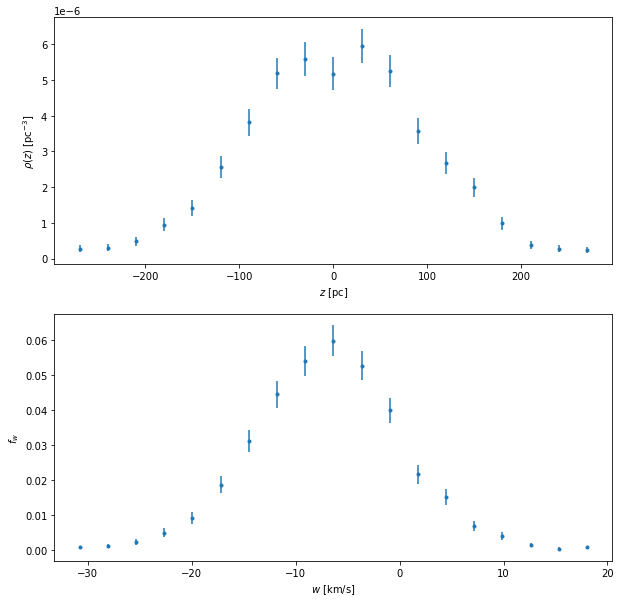

In [77]:
data, dim, w0, sigma_w, a_raw, name = load_data(1, number_files, velocity_files, velocity_popt_files)
print(name)
plot_data(data)

locs, scales, uni_list_DM, norm_list_DM = initialize_prior_dm(w0, sigma_w, a_raw, dim)

p0, ndim, nwalkers = initialize_walkers_dm(locs, scales, dim)

100%|██████████| 500/500 [00:32<00:00, 15.29it/s]


Multiprocessing took 32.8 seconds


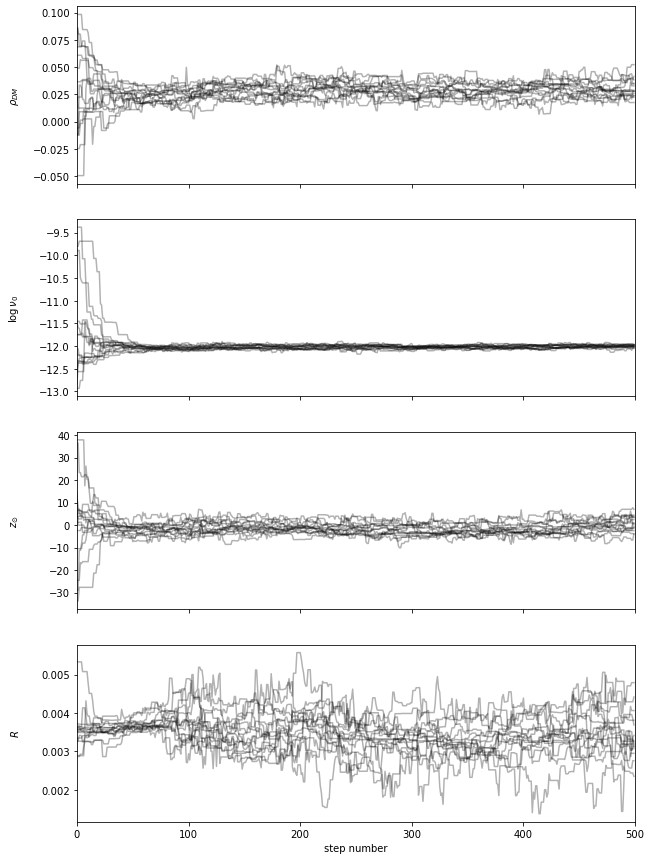

In [78]:
sampler = run_mcmc(
    nwalkers, ndim, p0, labels, log_posterior_simple_DM,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    cores=16, plot=True, step=500)

100%|██████████| 5000/5000 [05:26<00:00, 15.32it/s]


Multiprocessing took 326.5 seconds


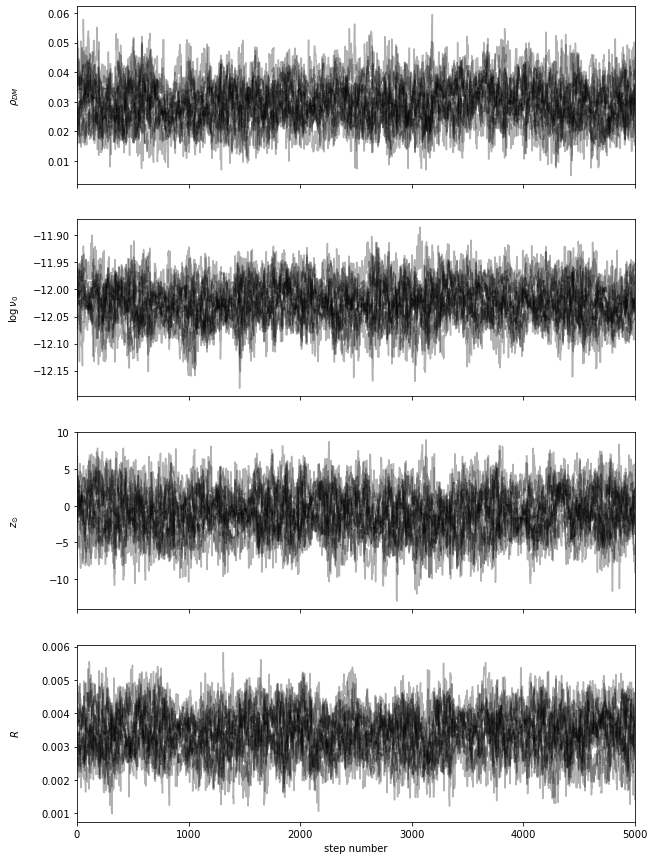

In [79]:
next_p0 = sampler.get_chain()[-1]
# next_p0 = sampler_new.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, labels, log_posterior_simple_DM,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    cores=16, plot=True, step=5000)

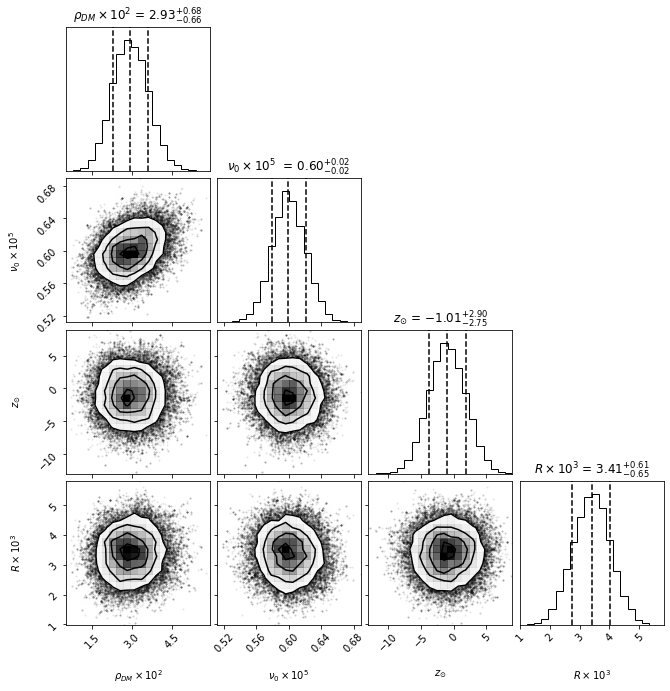

In [80]:
plot_corner_dm(sampler_new)

100%|██████████| 100/100 [00:02<00:00, 43.30it/s]


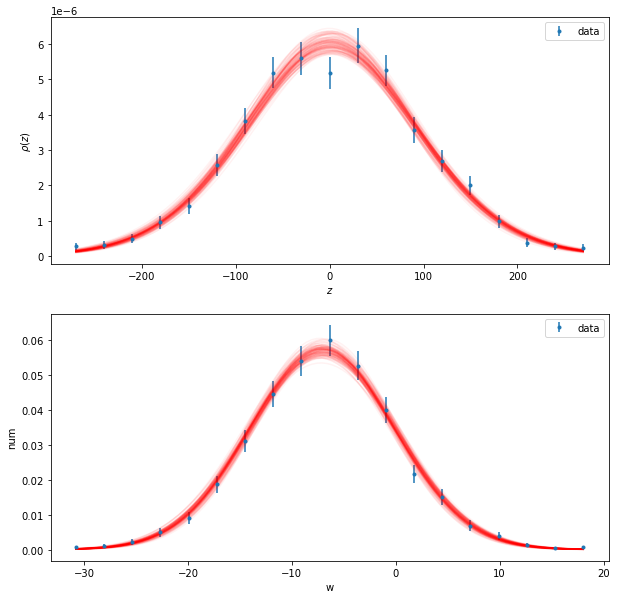

In [84]:
plot_fitting_dm(sampler_new, data, dim, rhos, sigmaz, alpha=0.05, n=100)

In [163]:
flat_samples = sampler_new.get_chain().copy()
log_posterior_chain = sampler_new.get_log_prob().copy()
# save priors
thetas = []
t0 = time()
for i, post in enumerate(log_posterior_chain.T):
    for samples, lg_posterior in zip(tqdm(flat_samples[:, i], desc=f"{i}/{nwalkers}", leave=False), post):
        theta = {
            "rhoDM": samples[0],
            "log_nu0": samples[1],
            "zsun": samples[2],
            "R": samples[3],
            "w0": samples[4:4+dim],
            "log_sigma_w": samples[4+dim:4+2*dim],
            "a": samples[4+2*dim:4+3*dim]
        }
        lg_prior = log_prior(theta, locs, scales, norm_list_DM, uni_list_DM)
        theta['log_prior'] = lg_prior
        theta['log_posterior'] = lg_posterior
        theta['log_likelihood'] = lg_posterior - lg_prior
        del theta['w0'], theta['log_sigma_w'], theta['a']
        for j in range(dim):
            theta[f"w0_{j}"] = samples[4+j]
            theta[f"log_sigma_w_{j}"] = samples[4+dim+j]
            theta[f"a_{j}"] = samples[4+2*dim+j]
        theta['walker'] = i
        thetas.append(theta)
# for samples in tqdm(flat_samples):
t1 = time()
print(f"Time: {t1-t0:.2f} s")
df = pd.DataFrame(thetas)
df

Time: 75.78 s


,rhoDM,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,walker
0,0.022151,-11.976125,-1.923822,0.002736,-0.129113,364.506111,364.635224,-7.043808,1.894014,1.043771,0
1,0.022151,-11.976125,-1.923822,0.002736,-0.129113,364.506111,364.635224,-7.043808,1.894014,1.043771,0
2,0.022151,-11.976125,-1.923822,0.002736,-0.129113,364.506111,364.635224,-7.043808,1.894014,1.043771,0
3,0.021361,-11.976760,-1.720834,0.002697,-0.202306,364.195585,364.397891,-7.030441,1.890483,1.040425,0
4,0.021361,-11.976760,-1.720834,0.002697,-0.202306,364.195585,364.397891,-7.030441,1.890483,1.040425,0
...,...,...,...,...,...,...,...,...,...,...,...
74995,0.035506,-11.985643,-2.011554,0.003043,0.306425,366.942236,366.635812,-6.957817,1.961872,1.148884,14
74996,0.035506,-11.985643,-2.011554,0.003043,0.306425,366.942236,366.635812,-6.957817,1.961872,1.148884,14
74997,0.035521,-11.985606,-2.011717,0.003043,0.305941,366.938876,366.632935,-6.957830,1.961924,1.149061,14
74998,0.029893,-11.999791,-1.949786,0.003228,0.442074,367.711947,367.269873,-6.952758,1.942084,1.081891,14


In [141]:
name

'gaia_(0.04)_(0.10).hdf5'

In [142]:
df_dm = vaex.from_pandas(df)
df_dm.export(join(data_dir, f"dm_simple_{name}.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.09s =  0.0m =  0.0h
 

# Checking

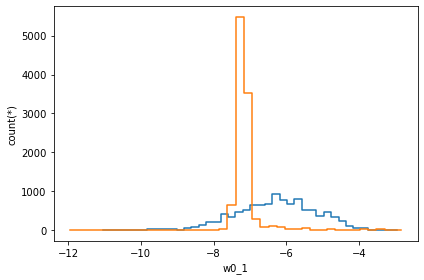

In [104]:
df_dm.viz.histogram('w0_0', shape=40)
df_dm.viz.histogram('w0_1', shape=40)